# MakeTimePlotsForHCERES2024

In [1]:
import os,sys,re
import h5py # one standard python package to work on hdf5 file


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns 
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


## Merra 2

In [3]:
top_merra2 = "../../../Merra2"

In [4]:
asm_merra2 = ["MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]
Nasm = len(asm_merra2)

In [5]:
aer_merra2 = ["MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv"]
Naer = len(aer_merra2)

In [6]:
df_asm = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in asm_merra2] 
df_aer = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in aer_merra2] 

In [7]:
df_asm_all = pd.concat(df_asm)
df_aer_all = pd.concat(df_aer)

## Auxtel data

In [8]:
path = "Data_Auxtel_FittAtm"

In [9]:
list_of_files = sorted(os.listdir(path))
list_of_files

['out_allfittedparams_selected_27sept-07dec2023.csv']

In [10]:
df = pd.read_csv(os.path.join(path,list_of_files[0]))

In [25]:
DATEMIN = pd.to_datetime(df["DATE-OBS"].min())
print(DATEMIN) 
DATEMIN = pd.to_datetime("2023-09-28 00:00:00")

2023-09-28 00:17:22.483504618+00:00


In [26]:
DATEMAX = pd.to_datetime(df["DATE-OBS"].max())
print(DATEMAX)
DATEMAX = pd.to_datetime("2023-12-09 00:00:00")

2023-12-08 04:51:38.708493603+00:00


In [11]:
rec = df.to_records()

In [12]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

411
403
390
356
355
283


In [13]:
df["filtered"] =filtered

In [14]:
stars = np.unique(rec["TARGET"])
print(stars)
Nstars = len(stars)

['HD009051' 'HD14943' 'HD160617' 'HD167060' 'HD185975' 'HD200654'
 'HD205905' 'HD2811' 'HD38666']


In [15]:
cmap = sns.color_palette("husl", Nstars)

In [16]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

In [34]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.9,1.1]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,10.]
ATMMINMAX["VAOD_y"] = [0.,0.1]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.9,1.1]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,10.]
ATMMINMAX["VAOD_x"] = [0.,0.1]
ATMMINMAX["A2_x"] = [0.7,1.3]

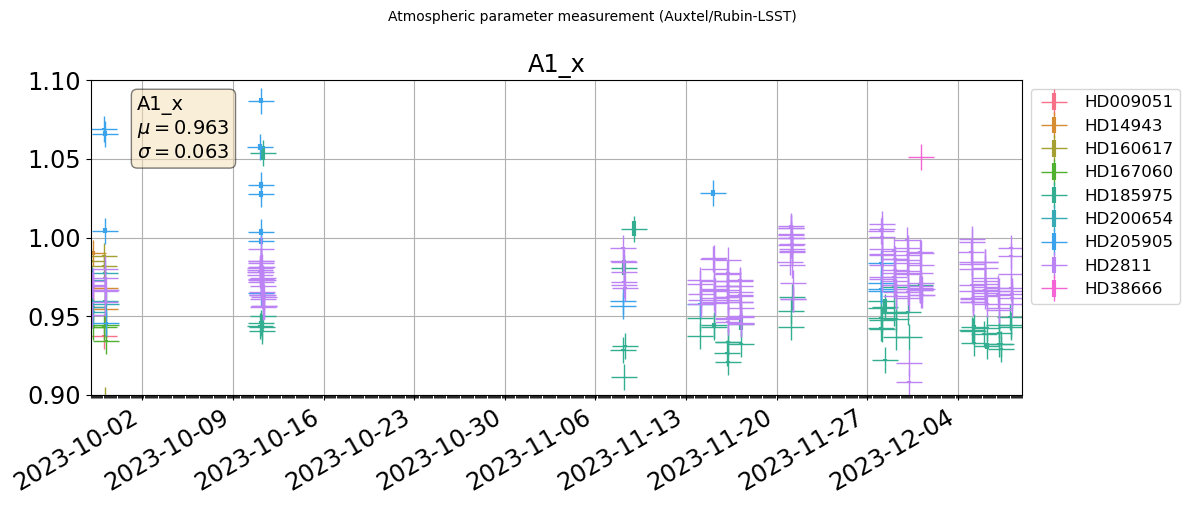

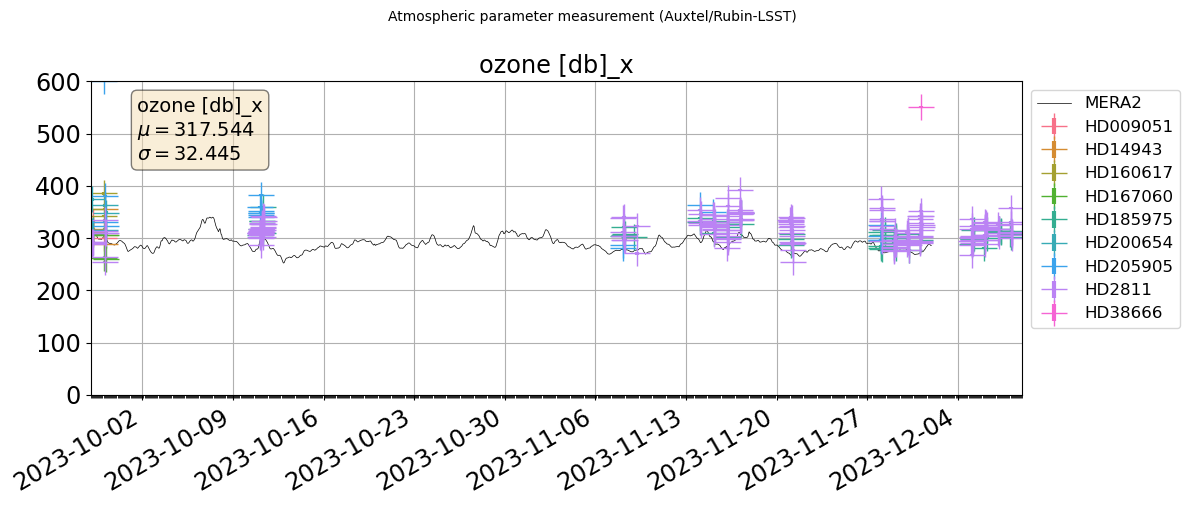

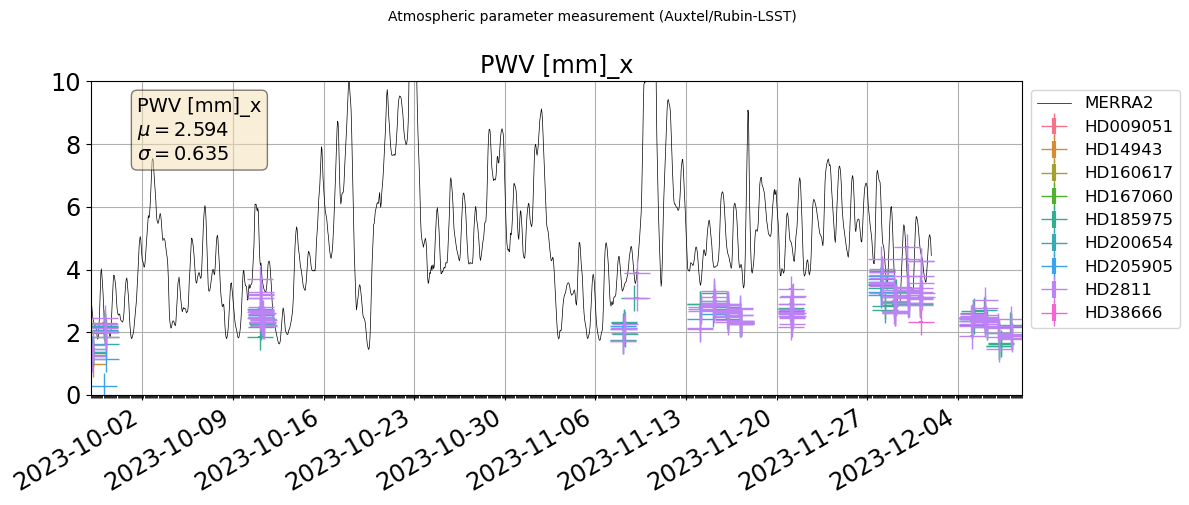

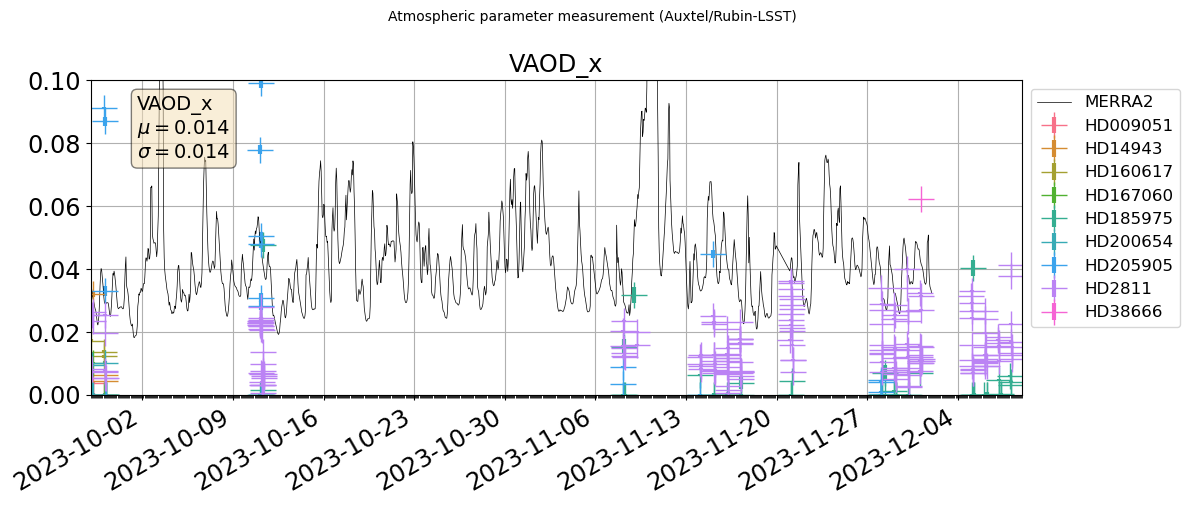

In [45]:
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=7)
hour_locator = mdates.HourLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m-%d") 


for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(12,5))
    for star in stars:
        idxcol = np.where(stars == star)[0][0]
        color = cmap[idxcol]
        
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",color=color,ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",color=color,ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    #ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    #ax.xaxis.set_minor_locator(day_locator)

    ax.xaxis.set_major_locator(day_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(hour_locator)

    ax.xaxis.set_major_formatter(year_month_formatter)
    ax.set_xlim(DATEMIN,DATEMAX)
    plt.gcf().autofmt_xdate()

    if col == "ozone [db]_x":
        ax.plot(pd.to_datetime(df_asm_all.index),df_asm_all.TO3,'k-',lw=0.5,label="MERA2")
    elif col == "PWV [mm]_x":
        ax.plot(pd.to_datetime(df_asm_all.index),df_asm_all.TQV,'k-',lw=0.5,label="MERRA2")
    elif col == "VAOD_x":
        ax.plot(pd.to_datetime(df_aer_all.index),df_aer_all.TOTEXTTAU,'k-',lw=0.5,label="MERRA2")

    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Atmospheric parameter measurement (Auxtel/Rubin-LSST) "
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()

    
    plt.show()